In [51]:
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="2"

In [52]:
!nvidia-smi

Fri Feb 21 11:06:44 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 570.86.15              Driver Version: 570.86.15      CUDA Version: 12.8     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA A100 80GB PCIe          On  |   00000000:17:00.0 Off |                    0 |
| N/A   42C    P0             58W /  300W |       1MiB /  81920MiB |      0%      Default |
|                                         |                        |             Disabled |
+-----------------------------------------+-----

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


In [53]:
from transformers import Qwen2_5_VLForConditionalGeneration, AutoTokenizer, AutoProcessor, AutoModel 
from qwen_vl_utils import process_vision_info

import torch
import json
import random
import io
import ast
from PIL import Image, ImageDraw, ImageFont
from PIL import ImageColor

import Levenshtein
import cv2
import numpy as np
import xml.etree.ElementTree as ET
import matplotlib.pyplot as plt

In [54]:
from segment_anything import sam_model_registry, SamAutomaticMaskGenerator, SamPredictor

sam_checkpoint = "sam_vit_h_4b8939.pth"
model_type = "vit_h"

device = "cuda"

sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
sam.to(device=device)

Sam(
  (image_encoder): ImageEncoderViT(
    (patch_embed): PatchEmbed(
      (proj): Conv2d(3, 1280, kernel_size=(16, 16), stride=(16, 16))
    )
    (blocks): ModuleList(
      (0-31): 32 x Block(
        (norm1): LayerNorm((1280,), eps=1e-06, elementwise_affine=True)
        (attn): Attention(
          (qkv): Linear(in_features=1280, out_features=3840, bias=True)
          (proj): Linear(in_features=1280, out_features=1280, bias=True)
        )
        (norm2): LayerNorm((1280,), eps=1e-06, elementwise_affine=True)
        (mlp): MLPBlock(
          (lin1): Linear(in_features=1280, out_features=5120, bias=True)
          (lin2): Linear(in_features=5120, out_features=1280, bias=True)
          (act): GELU(approximate='none')
        )
      )
    )
    (neck): Sequential(
      (0): Conv2d(1280, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (1): LayerNorm2d()
      (2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (3): LayerNorm2d

In [55]:


# default: Load the model on the available device(s)
model = Qwen2_5_VLForConditionalGeneration.from_pretrained(
    "Qwen/Qwen2.5-VL-7B-Instruct", torch_dtype="auto", device_map="auto"
)

# default processer
processor = AutoProcessor.from_pretrained("Qwen/Qwen2.5-VL-7B-Instruct")


Loading checkpoint shards:   0%|          | 0/5 [00:00<?, ?it/s]

In [56]:
#directory = "/home/jmurrugarral/VLM-Privacy"
#folder_path = "/home/jmurrugarral/datasets/BIV-Priv_Image/support_images"

directory = "/gpfs/projects/CascanteBonillaGroup/jmurrugarral/QWEN"
folder_path = "/gpfs/projects/CascanteBonillaGroup/datasets/BIV-Priv_Image/support_images"

In [62]:
from collections import Counter

additional_colors = [colorname for (colorname, colorcode) in ImageColor.colormap.items()]


def plot_bounding_boxes(im, bounding_boxes, input_width, input_height, image_width, image_height, json=False):
    """
    Plots bounding boxes on an image with markers for each a name, using PIL, normalized coordinates, and different colors.

    Args:
        img_path: The path to the image file.
        bounding_boxes: A list of bounding boxes containing the name of the object
         and their positions in normalized [y1 x1 y2 x2] format.
    """

    # Load the image
    img = im
    width, height = img.size
    # Create a drawing object
    draw = ImageDraw.Draw(img)

    # Define a list of colors
    colors = [
    'red',
    'green',
    'blue',
    'yellow',
    'orange',
    'pink',
    'purple',
    'brown',
    'gray',
    'beige',
    'turquoise',
    'cyan',
    'magenta',
    'lime',
    'navy',
    'maroon',
    'teal',
    'olive',
    'coral',
    'lavender',
    'violet',
    'gold',
    'silver',
    ] + additional_colors

    if json == False:

        # Parsing out the markdown fencing
        bounding_boxes = parse_json(bounding_boxes)

        #font = ImageFont.truetype("NotoSansCJK-Regular.ttc", size=14)

        try:
          json_output = ast.literal_eval(bounding_boxes)
        except Exception as e:
          end_idx = bounding_boxes.rfind('"}') + len('"}')
          truncated_text = bounding_boxes[:end_idx] + "]"
          json_output = ast.literal_eval(truncated_text)
    else:
        #json_output = ast.literal_eval(bounding_boxes)
        json_output = bounding_boxes

    bboxes = np.zeros((int(len(json_output)),4))
    labels = []

    # Iterate over the bounding boxes
    for i, bounding_box in enumerate(json_output):
      # Select a color from the list
      color = colors[i % len(colors)]

      bboxes[i,:] = np.array([int(bounding_box["bbox_2d"][0]/input_width * image_width),
                              int(bounding_box["bbox_2d"][1]/input_height * image_height),
                              int(bounding_box["bbox_2d"][2]/input_width * image_width),
                              int(bounding_box["bbox_2d"][3]/input_height * image_height)])



      # Convert normalized coordinates to absolute coordinates
      abs_y1 = int(bounding_box["bbox_2d"][1]/input_height * height)
      abs_x1 = int(bounding_box["bbox_2d"][0]/input_width * width)
      abs_y2 = int(bounding_box["bbox_2d"][3]/input_height * height)
      abs_x2 = int(bounding_box["bbox_2d"][2]/input_width * width)

      if abs_x1 > abs_x2:
        abs_x1, abs_x2 = abs_x2, abs_x1
        bboxes[i,0], bboxes[i,2] = bboxes[i,2], bboxes[i,0]


      if abs_y1 > abs_y2:
        abs_y1, abs_y2 = abs_y2, abs_y1
        bboxes[i,1], bboxes[i,3] = bboxes[i,3], bboxes[i,1]

      #bboxes[i,:] = np.array([abs_x1, abs_y1, abs_x2, abs_y2])

      # Draw the bounding box
      draw.rectangle(((abs_x1, abs_y1), (abs_x2, abs_y2)), outline=color, width=4)

      # Draw the text
      if "label" in bounding_box:
        draw.text((abs_x1 + 8, abs_y1 + 6), bounding_box["label"], fill=color)#, font=font)

      if "text_content" in bounding_box:
        labels.append(bounding_box["text_content"])

    # Display the image
    #img.show()

    return img, bboxes, labels

# @title Parsing JSON output
def parse_json(json_output):
    # Parsing out the markdown fencing
    lines = json_output.splitlines()
    for i, line in enumerate(lines):
        if line == "```json":
            json_output = "\n".join(lines[i+1:])  # Remove everything before "```json"
            json_output = json_output.split("```")[0]  # Remove everything after the closing "```"
            break  # Exit the loop once "```json" is found
    return json_output

def locate_private_content(img_full_path, prompt, temperature = 1, top_p = 0.8, grounding = True):

    max_new_tokens=1024
    image = Image.open(img_full_path)
    messages = [
        {
            "role": "system",
            "content": "You are a helpful assistant"
        },
        {
            "role": "user",
            "content": [
                {
                    "type": "text",
                    "text": prompt
                },
                {
                  "image": img_full_path
                }
            ]
        }
    ]

    text = processor.apply_chat_template(messages, tokenize=False, add_generation_prompt=True)
    inputs = processor(text=[text], images=[image], padding=True, return_tensors="pt").to('cuda')



    output_ids = model.generate(**inputs, max_new_tokens=1024)#, temperature= temperature, top_p = top_p)
    generated_ids = [output_ids[len(input_ids):] for input_ids, output_ids in zip(inputs.input_ids, output_ids)]
    output_text = processor.batch_decode(generated_ids, skip_special_tokens=True, clean_up_tokenization_spaces=True)

    input_height = inputs['image_grid_thw'][0][1]*14
    input_width = inputs['image_grid_thw'][0][2]*14
    response = output_text[0]
    #print(response)

    if grounding == True:
        image = Image.open(img_full_path)
        image_width, image_height = image.size
        image.thumbnail([1000, 1000], Image.Resampling.LANCZOS)

        if 'bbox_2d' in response:
            image, bboxes, labels = plot_bounding_boxes(image,response,input_width,input_height,image_width, image_height)
        else:
            image = image
            bboxes = None
            labels = None

    else:
        image  = image
        bboxes = None
        labels = None

    return response, image, bboxes, labels

def get_pseudo_detections(image_file, img_full_path, threshold_conf):
    #ans, img = locate_private_content(img_full_path, "Spotting all the text in the image with line-level, and output in JSON format.", temperature = 1, top_p=0.8)#, show_results = False)
    #ans, img = locate_private_content(img_full_path, "Describe the text with labels, and output in JSON format", temperature = 1, top_p=0.8)#, show_results = False)

    #ans, img = locate_private_content(img_full_path, "Which is the angle orientation of the file?.", temperature = 1, top_p=0.8)#, show_results = False)

    ans, img, bboxes, labels = locate_private_content(img_full_path, "Spotting all the text and provide a label in the image with line-level, and output in JSON format.", temperature = 1, top_p=0.8)#, show_results = False)

    return img, bboxes, labels

def warp_bboxes(bboxes, matrix):

    coord      = np.zeros((4,2))
    n          = bboxes.shape[0]

    for i in range(n):

        detection = bboxes[i,:]

        coord[0,:] = matrix @ np.array([detection[0], detection[1], 1])
        coord[1,:] = matrix @ np.array([detection[0], detection[3], 1])
        coord[2,:] = matrix @ np.array([detection[2], detection[1], 1])
        coord[3,:] = matrix @ np.array([detection[2], detection[3], 1])

        bboxes[i,:] = np.array([np.min(coord[:,0]),np.min(coord[:,1]),np.max(coord[:,0]),np.max(coord[:,1])])

    return bboxes

def rotate_image(image, angle, output_path):

    # Get image dimensions
    (h, w) = image.shape[:2]

    # Compute the center of the image
    center = (w // 2, h // 2)

    # Get the rotation matrix
    M = cv2.getRotationMatrix2D(center, angle, 1.0)

    print(M)
    
    # Compute the new bounding dimensions
    cos = np.abs(M[0, 0])
    sin = np.abs(M[0, 1])
    new_w = int((h * sin) + (w * cos))
    new_h = int((h * cos) + (w * sin))

    # Adjust the rotation matrix for translation
    M[0, 2] += (new_w / 2) - center[0]
    M[1, 2] += (new_h / 2) - center[1]

    if angle == 0:
        rotated = image
    elif angle == 90:
        rotated = cv2.rotate(image, cv2.ROTATE_90_COUNTERCLOCKWISE)
    elif angle == 180:
        rotated = cv2.rotate(image, cv2.ROTATE_180)
    elif angle == 270:
        rotated = cv2.rotate(image, cv2.ROTATE_90_CLOCKWISE)
    else:
        rotated = cv2.warpAffine(image, M, (new_w, new_h))

    M   = np.append(M, [[0,0,1]],axis=0)
    M_I = np.linalg.inv(M).astype(np.float32)

    # Save the rotated image
    cv2.imwrite(output_path, rotated)

    return M_I[0:2,:]

def jaccard_multiset(str1, str2):
    # Convert words to frequency counts
    counter1 = Counter(str1)
    counter2 = Counter(str2)
    
    # Compute intersection and union based on frequency counts
    intersection = sum(min(counter1[char], counter2[char]) for char in counter1 & counter2)
    union = sum(max(counter1[char], counter2[char]) for char in counter1 | counter2)
    
    return intersection / union if union != 0 else 0

def rotation_fine_grained(image, method):

    #directory = "/home/jmurrugarral/VLM-Privacy"
    cv2.imwrite('original.jpg', image)

    image_file = 'original.jpg'
    img_full_orig = os.path.join(directory, image_file)
    original_ans, _, _, _ = locate_private_content(img_full_orig, "Please output only the text content from the image without any additional descriptions or formatting.", temperature = 1, top_p=0.8, grounding = False)

    rotations = np.arange(0,360,10)
    print(rotations)
    #[0, 45, 90, 135, 180, 215, 270, 315]
    max_distancia, min_distancia = -1e9, 1e9
    new_bboxes = np.empty((0,4))#np.array([])

    new_image = None
    for rotation in [0,90,180,240, 250, 270]:#[0,90,180,270]:#[0, 45, 90, 135, 180, 225, 270, 315]:#rotations:


        image_file = 'rotated.jpg'
        matrix = rotate_image(image, rotation, image_file)

        img_full_path = os.path.join(directory, image_file)
        image2, bboxes, labels = get_pseudo_detections(image_file, img_full_path, 0.8);

        
        plt.imshow(image2)
        plt.show()
        
        image2 = cv2.imread(image_file)
        (h, w) = image2.shape[:2]

        temp_bboxes = warp_bboxes(bboxes, matrix)

        if method == 1:

            new_image = image.copy()
            for box in temp_bboxes:
                new_image[int(box[1]):int(box[3]),int(box[0]):int(box[2])] = 0

            cv2.imwrite('erased.jpg', new_image)


            image_file = 'erased.jpg'
            img_full_path = os.path.join(directory, image_file)
            masked_ans, _, _, _ = locate_private_content(img_full_path, "Please output only the text content from the image without any additional descriptions or formatting.", temperature = 1, top_p=0.8, grounding = False)

            distancia = Levenshtein.distance(original_ans, masked_ans)
            if distancia > max_distancia:
                max_distancia = distancia
                new_bboxes = temp_bboxes

        elif method == 2:

            new_image = np.zeros(image.shape).astype(np.uint8)
            for box in temp_bboxes:
                new_image[int(box[1]):int(box[3]),int(box[0]):int(box[2])] = image[int(box[1]):int(box[3]),int(box[0]):int(box[2])]

            cv2.imwrite('erased.jpg', new_image)

            image_file = 'erased.jpg'
            img_full_path = os.path.join(directory, image_file)
            masked_ans, _, _,_ = locate_private_content(img_full_path, "Please output only the text content from the image without any additional descriptions or formatting.", temperature = 1, top_p=0.8, grounding = False)

            orig_tam = len(original_ans)
            grained  = masked_ans.split('\n')

            distancia = 0
            for grain in grained:
                if grain in original_ans:
                    distancia+=1

            if distancia > max_distancia:
                max_distancia = distancia
                new_bboxes = temp_bboxes

        elif method ==3:

            distancia = 0
            for box, label in zip(temp_bboxes, labels):
                new_image = np.zeros(image.shape).astype(np.uint8)
                new_image[int(box[1]):int(box[3]),int(box[0]):int(box[2])] = image[int(box[1]):int(box[3]),int(box[0]):int(box[2])]


                
                cv2.imwrite('detection.jpg', new_image)


                image_file = 'detection.jpg'
                img_full_path = os.path.join(directory, image_file)
                ans, _, _,_  = locate_private_content(img_full_path, "Please output only the text content from the image without any additional descriptions or formatting.", temperature = 1, top_p=0.8, grounding = False)

                distancia += (2 - Levenshtein.distance(ans, label) )

            if distancia > max_distancia:
                max_distancia = distancia
                new_bboxes = temp_bboxes

        elif method == 4:

            distancia = 0
            new_image = np.zeros(image.shape).astype(np.uint8)
            for box, label in zip(temp_bboxes, labels):
                new_image = np.zeros(image.shape).astype(np.uint8)
                new_image[int(box[1]):int(box[3]),int(box[0]):int(box[2])] = image[int(box[1]):int(box[3]),int(box[0]):int(box[2])]

                cv2.imwrite('detection.jpg', new_image)


                image_file = 'detection.jpg'
                img_full_path = os.path.join(directory, image_file)
                ans, _, _,_  = locate_private_content(img_full_path, "Does this image contain the word: " + label, temperature = 1, top_p=0.8, grounding = False)

                if "Yes" in ans or "yes" in ans:
                    distancia+=1
                #print(ans)

                #distancia += (2 - Levenshtein.distance(ans, label) )

            if distancia > max_distancia:
                max_distancia = distancia
                new_bboxes = temp_bboxes

        elif method == 5:

            distancia = 0
            new_image = np.zeros(image.shape).astype(np.uint8)
            for id_box, (box, label) in enumerate(zip(temp_bboxes, labels)):
                new_image = np.zeros(image.shape).astype(np.uint8)
                new_image[int(box[1]):int(box[3]),int(box[0]):int(box[2])] = image[int(box[1]):int(box[3]),int(box[0]):int(box[2])]

                cv2.imwrite('detection.jpg', new_image)


                image_file = 'detection.jpg'
                img_full_path = os.path.join(directory, image_file)
                ans, _, _,_  = locate_private_content(img_full_path, "Please output only the text content from the image without any additional descriptions or formatting.", temperature = 1, top_p=0.8, grounding = False)

                
                #print('ANS')
                #print(ans)
                #print('LABEL')
                #print(label)
                distancia = jaccard_multiset(ans, label) 
                #print('distancia')
                #print(distancia)
                
                if distancia >=0.5:
                    #plt.imshow(cv2.cvtColor(new_image, cv2.COLOR_BGR2RGB))
                    #plt.show()

                    #print(ans)
                    #print(label)
                    #print(temp_bboxes[id_box, :][np.newaxis, :])
                    new_bboxes = np.append(new_bboxes, temp_bboxes[id_box, :][np.newaxis, :], axis=0)
                    #print(new_bboxes)


    #plt.imshow(cv2.cvtColor(new_image, cv2.COLOR_BGR2RGB))
    #plt.show()

    return new_image, new_bboxes


[[ 16   4]
 [ 75 401]
 [726 525]
 [708   2]]
Homography Matrix:
[[ 6.84849941e-03  2.36958080e+00 -9.58789917e+00]
 [-1.45520429e+00  5.00835128e-02  1.03018447e+03]
 [ 5.04121199e-04 -2.41100880e-04  1.00000000e+00]]


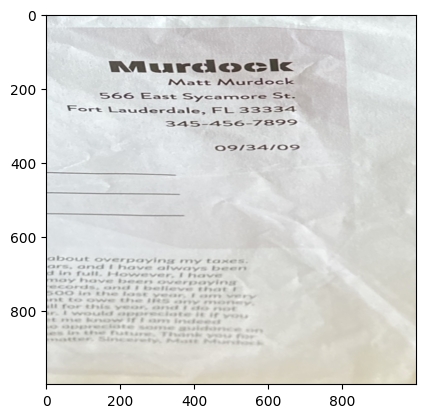

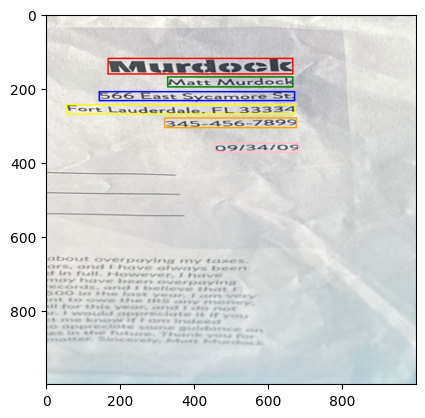

[  0  10  20  30  40  50  60  70  80  90 100 110 120 130 140 150 160 170
 180 190 200 210 220 230 240 250 260 270 280 290 300 310 320 330 340 350]
[[ 1.  0.  0.]
 [-0.  1.  0.]]


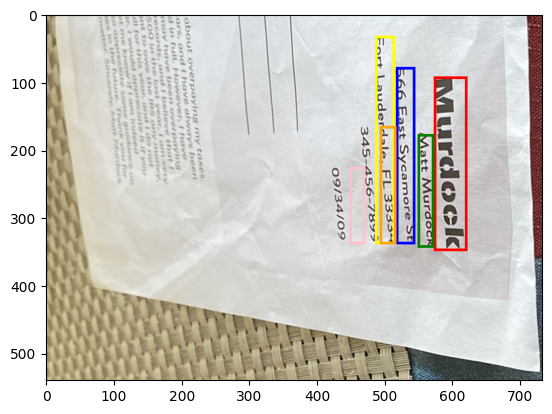

[[ 6.123234e-17  1.000000e+00  9.600000e+01]
 [-1.000000e+00  6.123234e-17  6.360000e+02]]


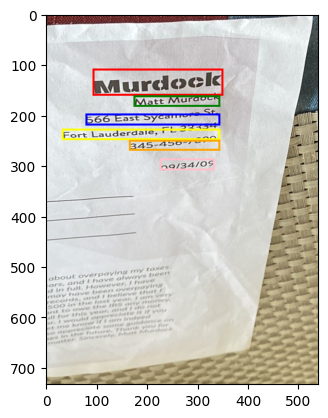

[[-1.0000000e+00  1.2246468e-16  7.3200000e+02]
 [-1.2246468e-16 -1.0000000e+00  5.4000000e+02]]


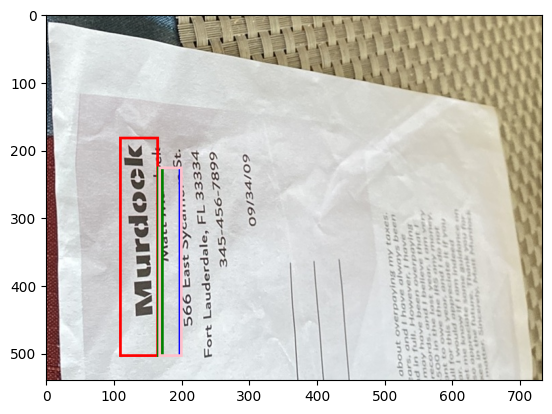

[[-5.00000000e-01 -8.66025404e-01  7.82826859e+02]
 [ 8.66025404e-01 -5.00000000e-01  8.80347022e+01]]


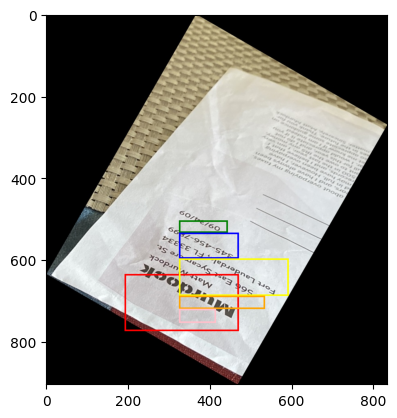

[[-3.42020143e-01 -9.39692621e-01  7.44896380e+02]
 [ 9.39692621e-01 -3.42020143e-01  1.84179395e+01]]


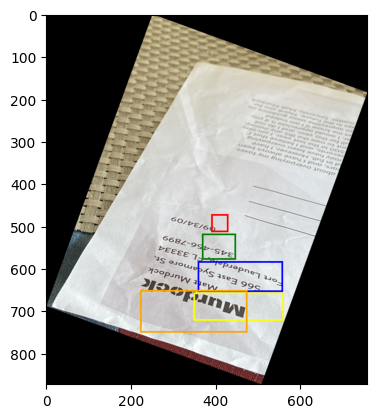

[[-1.8369702e-16 -1.0000000e+00  6.3600000e+02]
 [ 1.0000000e+00 -1.8369702e-16 -9.6000000e+01]]


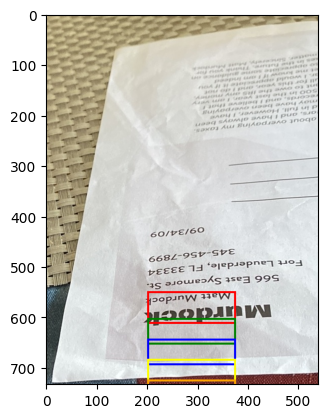

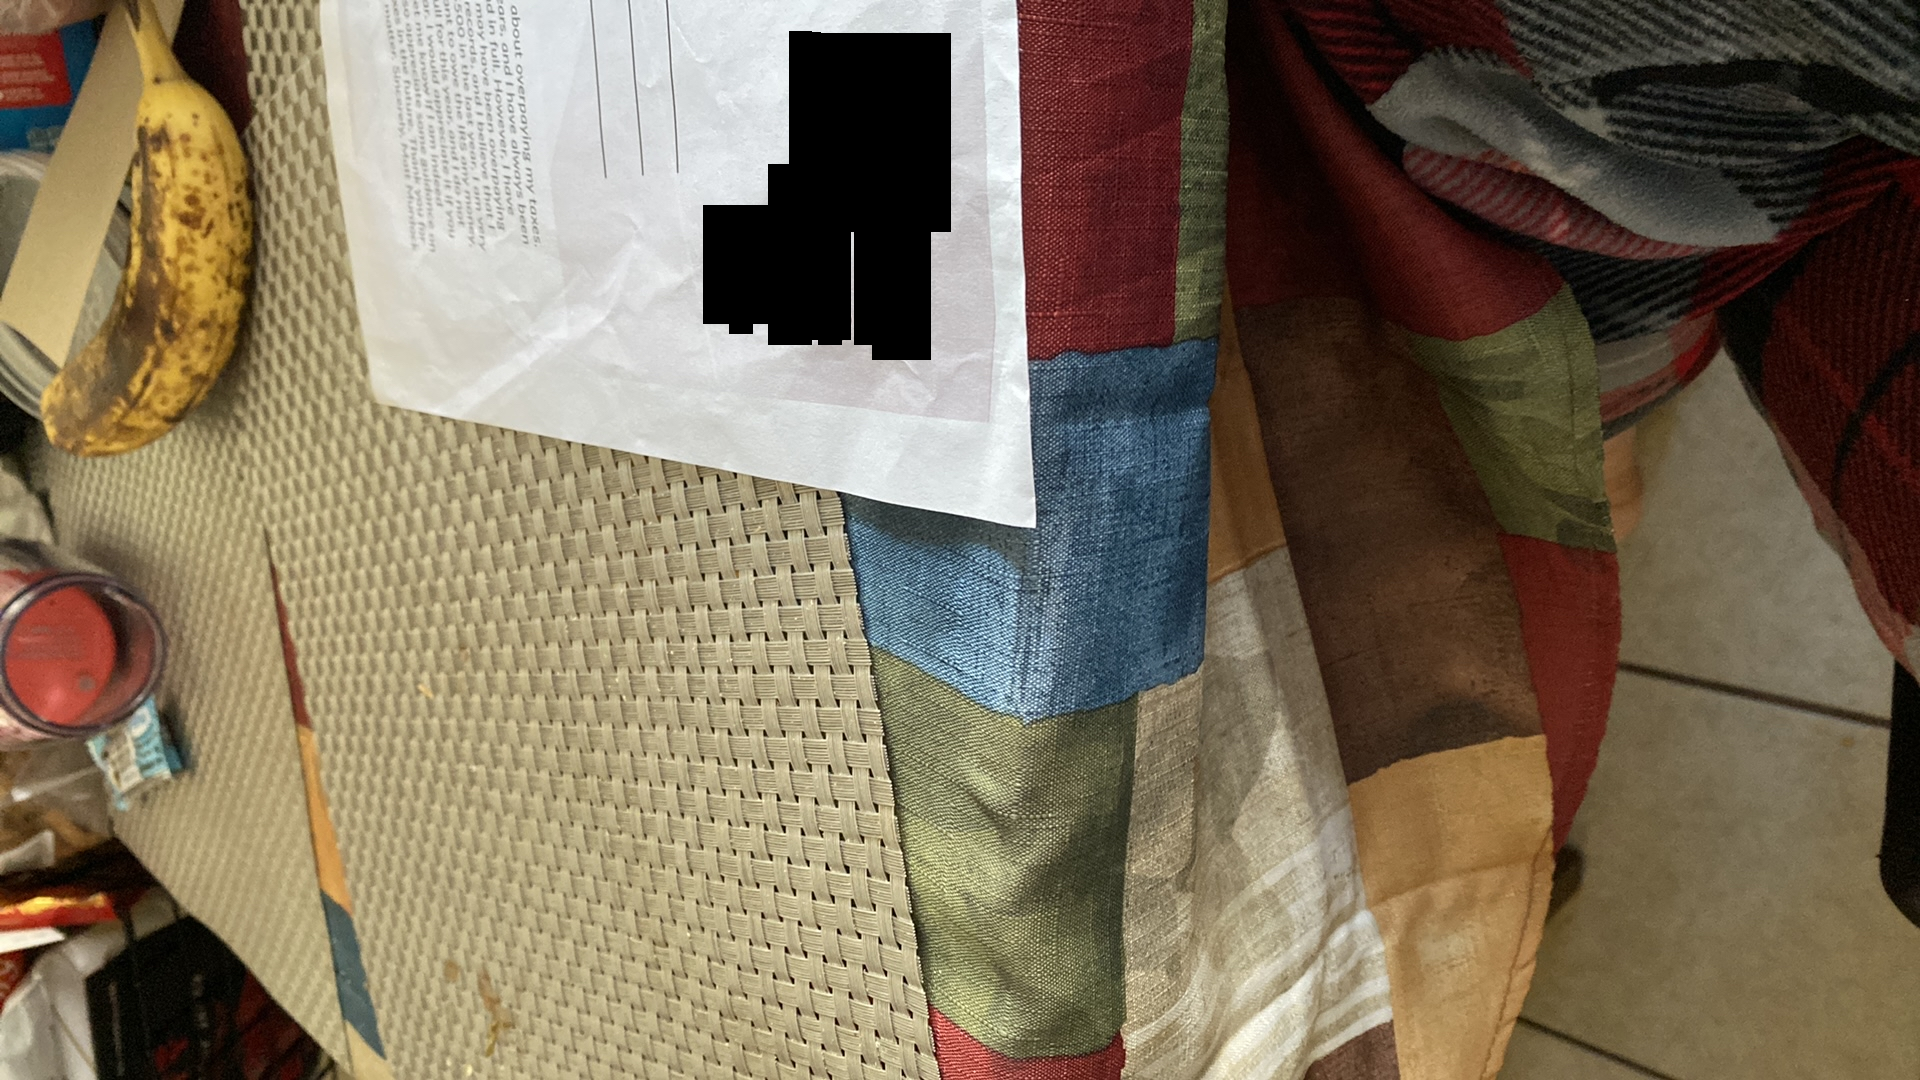

One Image, Time: 77.892599 seconds


In [63]:
import glob
import time

def show_anns(anns):
    if len(anns) == 0:
        return
    sorted_anns = sorted(anns, key=(lambda x: x['area']), reverse=True)
    ax = plt.gca()
    ax.set_autoscale_on(False)

    img = np.ones((sorted_anns[0]['segmentation'].shape[0], sorted_anns[0]['segmentation'].shape[1], 4))
    img[:,:,3] = 0
    for ann in sorted_anns:
        m = ann['segmentation']
        color_mask = np.concatenate([np.random.random(3), [0.35]])
        img[m] = color_mask
    ax.imshow(img)


def set_zero_outside_mask(image, mask):
    """Sets pixel values outside the mask to 0."""

    # Ensure image and mask have compatible shapes
    if image.shape[:2] != mask.shape:
        raise ValueError("Image and mask must have the same height and width.")

    # Create a copy of the image to avoid modifying the original
    masked_image = image.copy()

    # Set values outside mask to 0
    masked_image[~mask] = 0

    return masked_image

#folder_path = "/home/jmurrugarral/datasets/BIV-Priv_Image/support_images"

#folder_path = "/gpfs/projects/CascanteBonillaGroup/datasets/BIV-Priv_Image/query_images"

# List all files (non-recursively)
files = glob.glob(folder_path + "/*")

files = [files[1]]#[files[1],files[2],files[3],files[4], files[5], files[6],files[7], files[8]]

mask_generator = SamAutomaticMaskGenerator(sam)

for ind, file in enumerate(files):

   #ans, img, bboxes = locate_private_content(file, "Locate paper document in the image, and output in JSON format.", temperature = 1, top_p=0.8)#, show_results = False)    
    ans, img, bboxes, _ = locate_private_content(file, "Locate paper document in the image, and output in JSON format.", temperature = 1, top_p=0.8)#, show_results = False)
    
    if bboxes is not None:

        start_time = time.time()
        
        img = Image.open(file)        
        crop_x1 = bboxes[0][0]
        crop_y1 = bboxes[0][1]

        
        image = img.crop([bboxes[0][0],bboxes[0][1],bboxes[0][2],bboxes[0][3]])
        w, h = image.size

        #plt.imshow(image)
        #plt.show()

        image_to_sam = cv2.cvtColor(np.array(image), cv2.COLOR_BGR2RGB)
        masks = mask_generator.generate(image_to_sam)

        masked_image = set_zero_outside_mask(image_to_sam, masks[0]['segmentation'])
        thresh = masks[0]['segmentation'].astype(np.uint8)

        contours, _ = cv2.findContours(thresh, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE) 
        sorted_contours = sorted(contours, key=cv2.contourArea, reverse=True)

        cnt = sorted_contours[0] 

        x, y, w, h = cv2.boundingRect(cnt) 
  
        img = np.array(image)
        img = cv2.rectangle(img, (x, y), (x+w, y+h), (0, 255, 0), 2) 

        epsilon = 0.02 * cv2.arcLength(cnt, True)
        corners = cv2.approxPolyDP(cnt, epsilon, True)

        for corner in corners:
            cv2.circle(img, tuple(corner[0]), 10, (0, 0, 255), -1)

        rect = cv2.minAreaRect(cnt)
        box = cv2.boxPoints(rect)
        box = box.astype(int)
        img = cv2.polylines(img, [box], 1, (255,0,0), 2)

        src_points = np.array(corners).reshape(-1,2)
        print(src_points)

        dst_points = np.array([  
            [0, 1000],
            [1000, 1000],
            [1000, 0],
            [0, 0],
        ], dtype=np.float32)


        # Compute the homography matrix
        H, status = cv2.findHomography(src_points, dst_points, cv2.RANSAC)

        print("Homography Matrix:")
        print(H)

        # Warp the source image to align with the destination image
        height, width, channels = (1000, 1000, 3)
        warped_img = cv2.warpPerspective(np.array(image), H, (width, height))

        plt.imshow(warped_img)
        plt.show()
        

        cv2.imwrite('masked_himage.jpg', warped_img)

        image_file = 'masked_himage.jpg'
        img_full_path = os.path.join(directory, image_file)
        image2, bboxes, labels = get_pseudo_detections(image_file, img_full_path, 0.8);

        
        plt.imshow(image2)
        plt.show()
 
        if w > 28 and h > 28:

            from IPython.display import display
            
            method = 5
            image, boxes = rotation_fine_grained(cv2.cvtColor(np.array(image), cv2.COLOR_BGR2RGB), method) 
            #_, boxes = rotation_fine_grained(cv2.cvtColor(np.array(image), cv2.COLOR_BGR2RGB), None);

            #print(boxes)
            img = Image.open(file)
            draw = ImageDraw.Draw(img)
            for box in boxes:
                draw.rectangle([crop_x1+int(box[0]),crop_y1+int(box[1]),crop_x1+int(box[2]),crop_y1+int(box[3])], fill=(0, 0, 0))  # Negro para imágenes RGB
            index = str(ind)
            #img.show()

            display(img)                
            img.save('output/result_0_'+index.zfill(3)+'.png')

        end_time = time.time()
        print(f"One Image, Time: {end_time - start_time:.6f} seconds")        